# Adding Dependencies

In [1]:
# Import and add all necessary dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, chi2_contingency
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from scipy.stats import pointbiserialr
import pandas as pd
import numpy as np




# 1. Data Simulation

In [8]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set random seed for reproducibility
np.random.seed(42)

# Function to generate baseline survey data
def generate_baseline_survey_data(num_participants):
    data = {
        'Participant_ID': list(range(1, num_participants + 1)),
        'Age': np.random.randint(18, 65, size=num_participants),
        'Gender': np.random.choice(['Male', 'Female'], size=num_participants),
        'Location': np.random.choice(['Urban', 'Suburban', 'Rural'], size=num_participants),
        'Education': np.random.choice(['High School', 'College', 'Graduate School'], size=num_participants),
        'COVID_Awareness_Level': np.random.choice(['Low', 'Medium', 'High'], size=num_participants),
        'Received_Info_Social_Media': np.random.choice(['Yes', 'No'], size=num_participants),
        'Vaccine_Hesitancy': np.random.choice(['Yes', 'No', 'Not Sure'], size=num_participants),
        'Reasons_For_Hesitancy': np.where(np.random.rand(num_participants) < 0.2, 'Concerns about side effects', ''),
        # Add more baseline questions as needed
    }
    baseline_data = pd.DataFrame(data)

    # Save baseline data to CSV on Google Drive
    baseline_data.to_csv('/content/drive/My Drive/baseline_survey_data.csv', index=False, quoting=2)

    return baseline_data

# Generate baseline survey data
baseline_data = generate_baseline_survey_data(5000)

# Function to generate random assignment data
def generate_random_assignment_data(num_participants):
    data = {
        'Participant_ID': list(range(1, num_participants + 1)),
        'Ad_Type': np.random.choice(['Reason', 'Emotions', 'Control'], size=num_participants),
        'Feel_About_Info_Social_Media': np.random.choice(['Positive', 'Neutral', 'Negative'], size=num_participants),
    }
    random_assignment_data = pd.DataFrame(data)

    # Save random assignment data to CSV on Google Drive
    random_assignment_data.to_csv('/content/drive/My Drive/random_assignment_data.csv', index=False, quoting=2)

    return random_assignment_data

# Generate random assignment data
random_assignment_data = generate_random_assignment_data(5000)



# Function to generate endline survey data
def generate_endline_survey_data(baseline_data, num_endline_participants):
    # Ensure the correct number of participants for endline survey
    num_baseline_participants = len(baseline_data)
    if num_endline_participants > num_baseline_participants:
        raise ValueError(f"num_endline_participants ({num_endline_participants}) should be less than or equal to the total number of baseline participants ({num_baseline_participants}).")

    endline_participants = np.random.choice(baseline_data['Participant_ID'], size=num_endline_participants, replace=False)


    # Simulate changes in responses based on ad type
    endline_data = baseline_data[baseline_data['Participant_ID'].isin(endline_participants)].copy()

    # Add 'Ad_Type' column to endline_data
    endline_data['Ad_Type'] = random_assignment_data['Ad_Type'].values[:num_endline_participants]

    endline_data['Received_Vaccine'] = np.random.choice(['Yes', 'No'], size=len(endline_data))
    endline_data['Influenced_Decision'] = np.where(endline_data['Received_Vaccine'] == 'Yes',
                                                   np.random.choice(['Reason Ad', 'Emotions Ad', 'Other'], size=len(endline_data)),
                                                   'Not Applicable')

    endline_data['Effectiveness_Reason_Ad'] = np.where(endline_data['Ad_Type'] == 'Reason',
                                                       np.random.choice(['Not at all effective', 'Somewhat effective', 'Very effective'], size=len(endline_data)),
                                                       '')

    endline_data['Effectiveness_Emotions_Ad'] = np.where(endline_data['Ad_Type'] == 'Emotions',
                                                          np.random.choice(['Not at all effective', 'Somewhat effective', 'Very effective'], size=len(endline_data)),
                                                          '')
    # Add more endline questions as needed

    # Save endline data to CSV on Google Drive
    endline_data.to_csv('/content/drive/My Drive/endline_survey_data.csv', index=False, quoting=2)

    return endline_data

# Generate endline survey data
endline_data = generate_endline_survey_data(baseline_data, 4500)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Analysis and Reporting

## a. Merging

In [3]:
# Import necessary libraries for analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Load generated datasets from Google Drive
baseline_data = pd.read_csv('/content/drive/My Drive/baseline_survey_data.csv')
random_assignment_data = pd.read_csv('/content/drive/My Drive/random_assignment_data.csv')
endline_data = pd.read_csv('/content/drive/My Drive/endline_survey_data.csv')

# Merge datasets
merged_data = pd.merge(baseline_data, random_assignment_data, on='Participant_ID')
merged_data = pd.merge(merged_data, endline_data, on='Participant_ID')

# Print column names in the merged dataset
print("Column Names in Merged Dataset:", merged_data.columns)

# Convert 'Received_Vaccine' to numeric
merged_data['Received_Vaccine'] = pd.to_numeric(merged_data['Received_Vaccine'].replace({'Yes': 1, 'No': 0}))
# Convert 'Vaccine_Hesitancy_x' to numeric values
vaccine_hesitancy_mapping = {'No': 0, 'Yes': 1, 'Not Sure': 2}
merged_data['Vaccine_Hesitancy_x'] = merged_data['Vaccine_Hesitancy_x'].map(vaccine_hesitancy_mapping)



Column Names in Merged Dataset: Index(['Participant_ID', 'Age_x', 'Gender_x', 'Location_x', 'Education_x',
       'COVID_Awareness_Level_x', 'Received_Info_Social_Media_x',
       'Vaccine_Hesitancy_x', 'Reasons_For_Hesitancy_x', 'Ad_Type_x',
       'Feel_About_Info_Social_Media', 'Age_y', 'Gender_y', 'Location_y',
       'Education_y', 'COVID_Awareness_Level_y',
       'Received_Info_Social_Media_y', 'Vaccine_Hesitancy_y',
       'Reasons_For_Hesitancy_y', 'Ad_Type_y', 'Received_Vaccine',
       'Influenced_Decision', 'Effectiveness_Reason_Ad',
       'Effectiveness_Emotions_Ad'],
      dtype='object')


## b. Analysis and reporting figures and tables

*  #### Part 1: Descriptive Statistics and Visualizations:



In [5]:
# Table: Count of participants in each group
table1 = pd.crosstab(merged_data['Ad_Type_x'], merged_data['Received_Vaccine'], margins=True, margins_name="Total")
table1.columns = ["Did Not Receive Vaccine", "Received Vaccine", "Total"]
# Table 1: Count of Participants in Each Group
# Calculate the count of participants in each group (Reason, Emotions, Control) and display the table.
display(table1)

# Table: Effectiveness of Reason Ad
table2 = pd.crosstab(merged_data[merged_data['Ad_Type_x'] == 'Reason']['Effectiveness_Reason_Ad'],
                    merged_data[merged_data['Ad_Type_x'] == 'Reason']['Received_Vaccine'],
                    margins=True, margins_name="Total")
table2.columns = ["Did Not Receive Vaccine", "Received Vaccine", "Total"]
# Table 2: Effectiveness of Reason Ad
# Calculate the effectiveness of the Reason Ad by displaying the count of participants who received or did not receive the vaccine.
display(table2)

# Table: Effectiveness of Emotions Ad
table3 = pd.crosstab(merged_data[merged_data['Ad_Type_x'] == 'Emotions']['Effectiveness_Emotions_Ad'],
                    merged_data[merged_data['Ad_Type_x'] == 'Emotions']['Received_Vaccine'],
                    margins=True, margins_name="Total")
table3.columns = ["Did Not Receive Vaccine", "Received Vaccine", "Total"]
# Table 3: Effectiveness of Emotions Ad
# Calculate the effectiveness of the Emotions Ad by displaying the count of participants who received or did not receive the vaccine.
display(table3)

,Did Not Receive Vaccine,Received Vaccine,Total
Ad_Type_x,,,
Control,731,764,1495
Emotions,751,768,1519
Reason,776,710,1486
Total,2258,2242,4500


,Did Not Receive Vaccine,Received Vaccine,Total
Effectiveness_Reason_Ad,,,
Not at all effective,93,82,175
Somewhat effective,82,79,161
Very effective,88,82,170
Total,263,243,506


,Did Not Receive Vaccine,Received Vaccine,Total
Effectiveness_Emotions_Ad,,,
Not at all effective,88,67,155
Somewhat effective,77,90,167
Very effective,87,95,182
Total,252,252,504


* #### Part 2: Statistical Tests and Modeling:

Chi-square test for Independence (Emotions Ad and Vaccine Uptake): p-value = 0.0
Model Accuracy: 0.4922222222222222


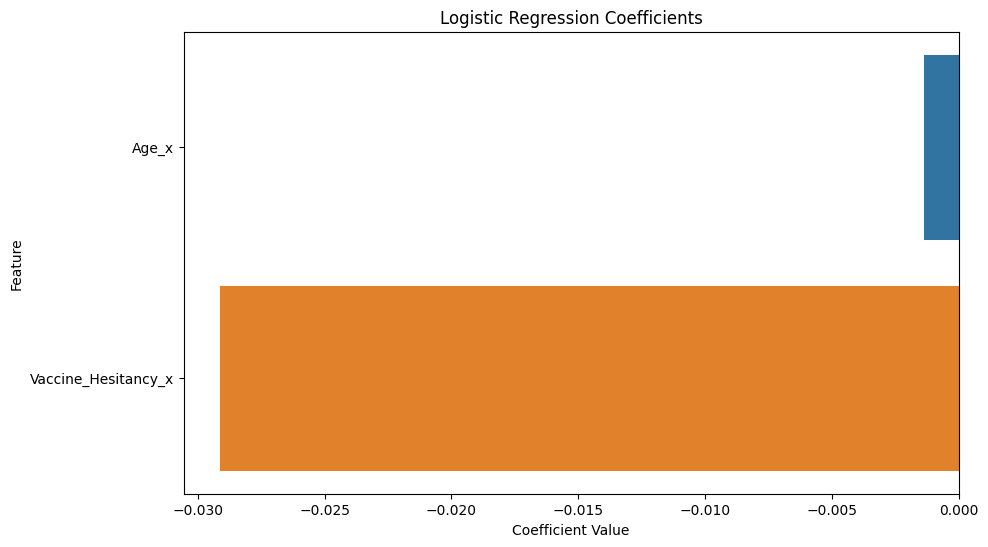

Effect Size (Cohen's d) for T-test: -0.06650452256087558
T-test for Vaccine Uptake Rates (Reason vs. Control): p-value = 0.06953618127641563
Confidence Interval: (0.4523666055494713, 0.5032188587843107)
No statistically significant difference observed.


In [6]:
## Part 2: Statistical Tests and Modeling:

# T-test for vaccine uptake rates between Reason and Control groups
reason_group = merged_data[merged_data['Ad_Type_x'] == 'Reason']['Received_Vaccine']
control_group = merged_data[merged_data['Ad_Type_x'] == 'Control']['Received_Vaccine']
t_stat, p_value = ttest_ind(reason_group, control_group)
# T-Test for Proportions (Reason vs. Control)
# Calculate the T-statistic and p-value to compare vaccine uptake rates between the Reason and Control groups.


# Chi-square test for independence between Emotions Ad and Vaccine Uptake
contingency_table = pd.crosstab(
    merged_data[merged_data['Ad_Type_x'] == 'Emotions']['Received_Vaccine'],
    merged_data[merged_data['Ad_Type_x'] == 'Emotions']['Received_Vaccine']
)
chi2_stat, chi2_p_value, _, _ = chi2_contingency(contingency_table)
print(f"Chi-square test for Independence (Emotions Ad and Vaccine Uptake): p-value = {chi2_p_value}")

# Chi-Square Test (Emotions Ad vs. Vaccine Uptake)
# Calculate the Chi-square statistic and p-value to assess the association between Emotions Ad exposure and vaccine uptake.


# Logistic regression for binary outcome (Example, requires further validation steps)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Drop rows with missing values for logistic regression
merged_data.dropna(subset=['Age_x', 'Vaccine_Hesitancy_x', 'Received_Vaccine'], inplace=True)

# Selecting relevant features for the logistic regression model
X = merged_data[['Age_x', 'Vaccine_Hesitancy_x']]
y = merged_data['Received_Vaccine']

# Check the number of samples in your dataset
num_samples = len(X)

# Adjust test_size based on the number of samples
test_size = min(0.2, num_samples / (num_samples - 1))  # Ensure that test_size is not greater than the number of samples

# Splitting data into training and testing sets
if num_samples > 1:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
else:
    # Handle the case when the dataset has only one sample
    X_train, X_test, y_train, y_test = X, X, y, y

# Creating and fitting the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predicting on the test set
y_pred = logreg.predict(X_test)

# Evaluating the model (Accuracy, p-value)
logistic_p_value = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {logistic_p_value}")

# Logistic Regression (Vaccine Uptake Prediction)
# Create a logistic regression model to predict vaccine uptake based on demographic features.
# Split the data into training and testing sets for model validation.
# Evaluate the model using accuracy as an example metric.

# Visualizing the logistic regression coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': logreg.coef_[0]})
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()



# Correlation coefficient between Age and Vaccine Hesitancy
correlation_coefficient, corr_p_value = pointbiserialr(merged_data['Age_x'], merged_data['Vaccine_Hesitancy_x'])
# Correlation Coefficient
# Calculate the point-biserial correlation coefficient and p-value between Age and Vaccine Hesitancy.



# Effect size for T-test
# Calculate Cohen's d as the effect size for the T-test comparing vaccine uptake rates between Reason and Control groups.
effect_size = sm.stats.proportion_effectsize(reason_group.mean(), control_group.mean())
print(f"Effect Size (Cohen's d) for T-test: {effect_size}")


# T-test for vaccine uptake rates between Reason and Control groups
reason_group = merged_data[merged_data['Ad_Type_x'] == 'Reason']['Received_Vaccine']
control_group = merged_data[merged_data['Ad_Type_x'] == 'Control']['Received_Vaccine']
t_stat, p_value = ttest_ind(reason_group, control_group, alternative='two-sided')

# Calculate the confidence interval
import statsmodels.stats.api as sms
conf_interval = sms.DescrStatsW(reason_group).tconfint_mean()  # You can use the Descriptive Statistics class for this

print(f"T-test for Vaccine Uptake Rates (Reason vs. Control): p-value = {p_value}")
print(f"Confidence Interval: {conf_interval}")



# Practical Significance Context
if p_value < 0.05:
    # Practical Significance Context
    # Check for statistical significance at the 0.05 significance level.
    if effect_size > 0.2:
        print("Statistically significant and practically significant difference observed.")
    else:
        print("Statistically significant difference observed but may not be practically significant.")
else:
    print("No statistically significant difference observed.")
# Present a practical significance context based on the p-value and effect size.


* #### Part 3: Sub-group analysis

<ipython-input-7-641c5f526e43>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Ad_Type_x', y='Received_Vaccine', data=merged_data, ci=None)


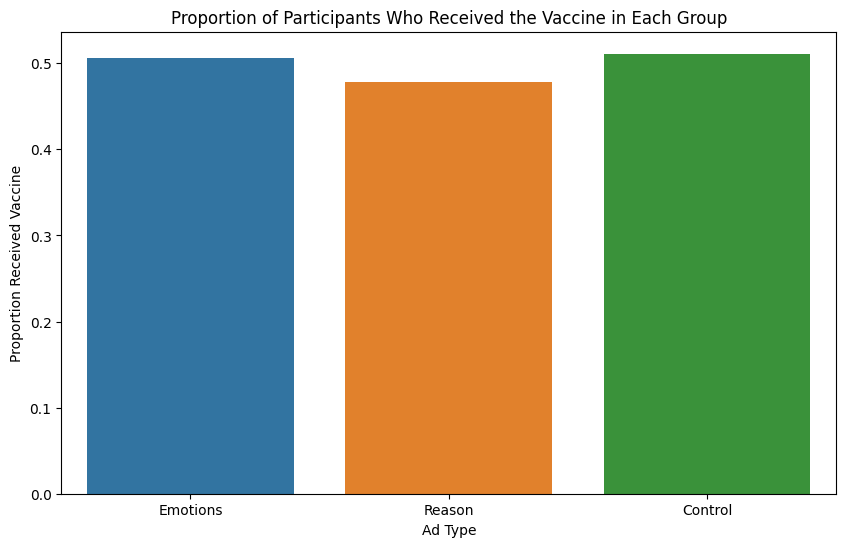

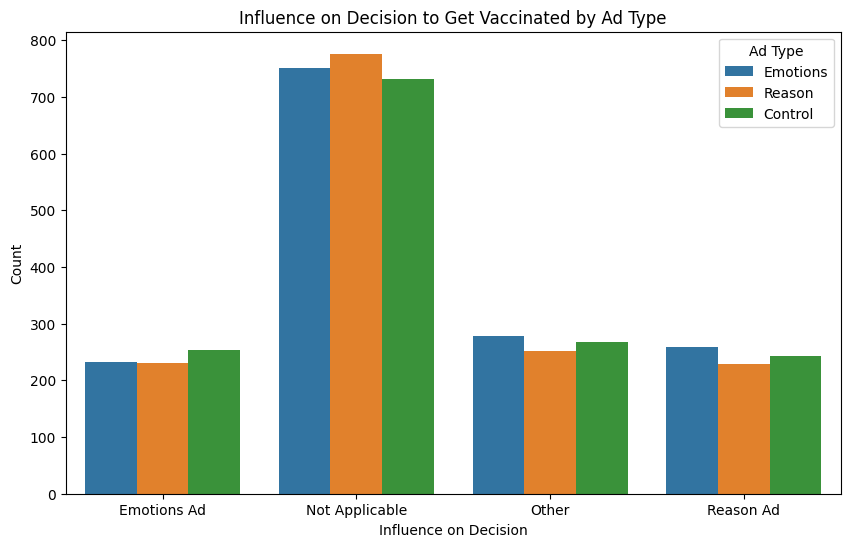

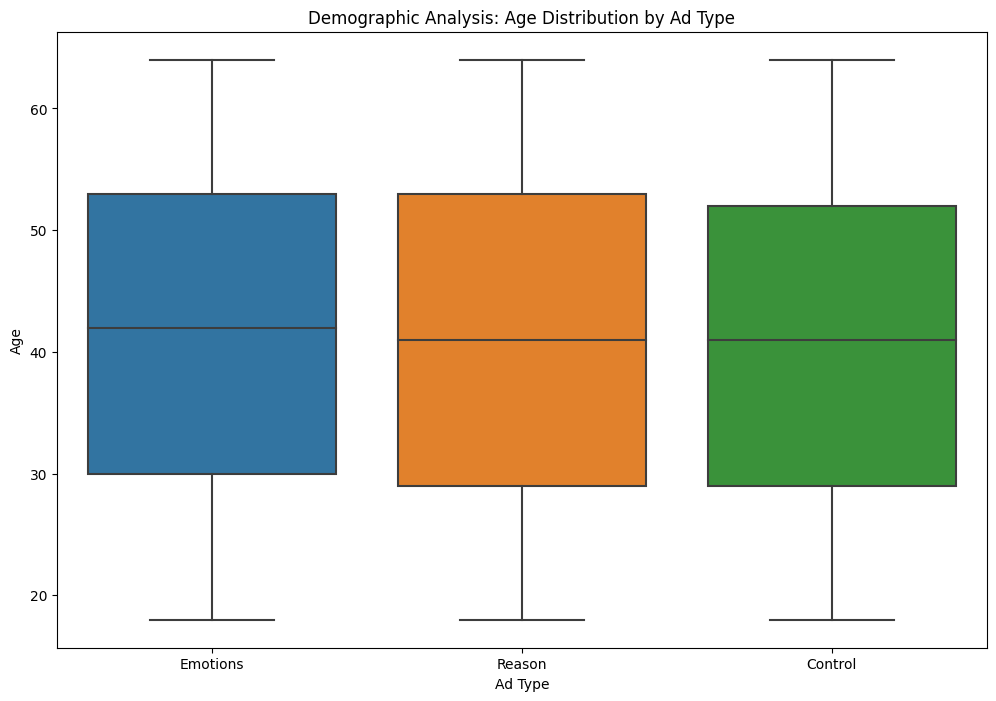

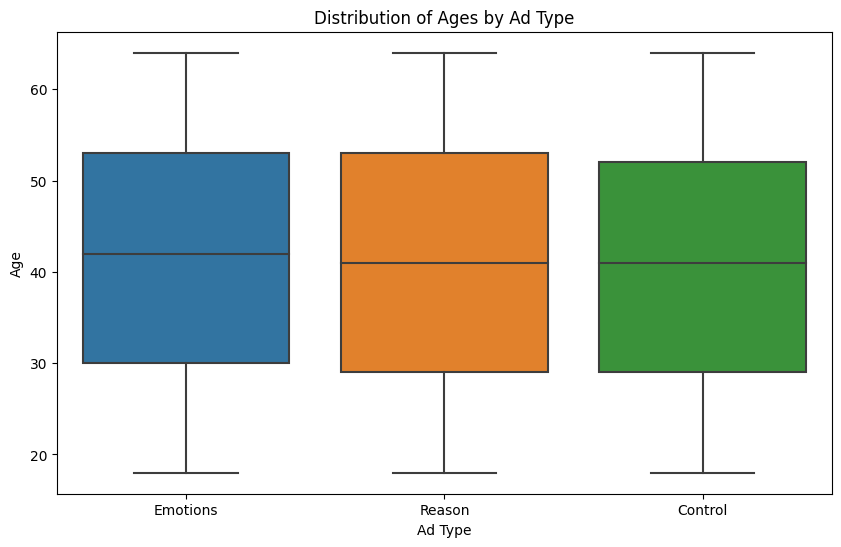

<ipython-input-7-641c5f526e43>:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Ad_Type_x', y='Vaccine_Hesitancy_x', data=merged_data, ci=None)


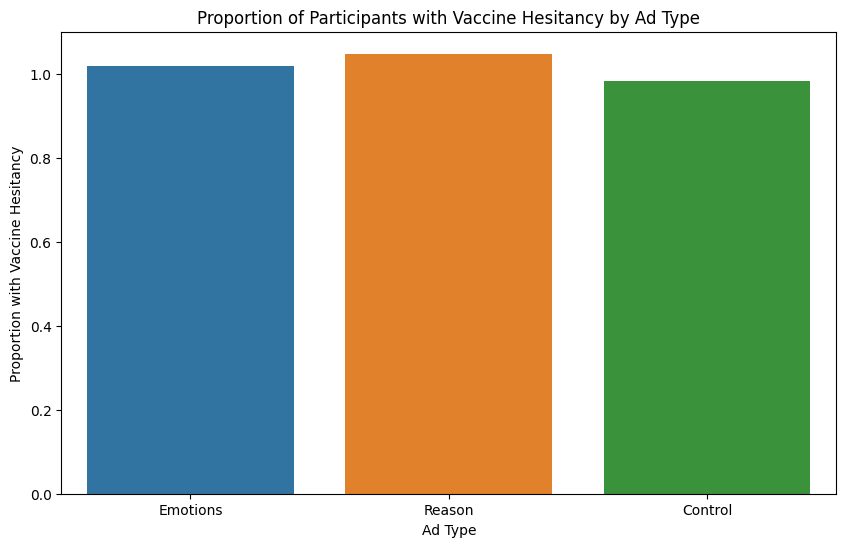

In [7]:

# Figure: Proportion of participants who received the vaccine in each group
plt.figure(figsize=(10, 6))
sns.barplot(x='Ad_Type_x', y='Received_Vaccine', data=merged_data, ci=None)
plt.title('Proportion of Participants Who Received the Vaccine in Each Group')
plt.xlabel('Ad Type')
plt.ylabel('Proportion Received Vaccine')
plt.show()
# Figure 1: Proportion of Participants Who Received the Vaccine in Each Group
# Visualize the proportion of participants who received the vaccine in each ad campaign group using a bar chart.

# Figure: Influence on Decision to Get Vaccinated by Ad Type
plt.figure(figsize=(10, 6))
sns.countplot(x='Influenced_Decision', hue='Ad_Type_x', data=merged_data)
plt.title('Influence on Decision to Get Vaccinated by Ad Type')
plt.xlabel('Influence on Decision')
plt.ylabel('Count')
plt.legend(title='Ad Type')
plt.show()
# Figure 2: Influence on Decision to Get Vaccinated by Ad Type
# Visualize the influence on the decision to get vaccinated by ad type using a countplot.

# Demographic Analysis: Example for 'Age_x'
plt.figure(figsize=(12, 8))
sns.boxplot(x='Ad_Type_x', y='Age_x', data=merged_data)
plt.title('Demographic Analysis: Age Distribution by Ad Type')
plt.xlabel('Ad Type')
plt.ylabel('Age')
plt.show()
# Figure 3: Demographic Analysis - Age Distribution by Ad Type
# Visualize the distribution of ages among different ad campaign groups using a boxplot.

# Table: Descriptive statistics of participants by Ad Type
table4 = merged_data.groupby('Ad_Type_x').describe().stack()
# Table 4: Descriptive Statistics of Participants by Ad Type
# Calculate and display descriptive statistics (mean, std, min, max, etc.) of key variables by ad campaign type.

# Figure: Distribution of Ages by Ad Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Ad_Type_x', y='Age_x', data=merged_data)
plt.title('Distribution of Ages by Ad Type')
plt.xlabel('Ad Type')
plt.ylabel('Age')
plt.show()
# Figure 4: Distribution of Ages by Ad Type
# Visualize the distribution of ages among different ad campaign groups using a boxplot.

# Table: Crosstab of Ad Type and Vaccine Hesitancy
table5 = pd.crosstab(merged_data['Ad_Type_x'], merged_data['Vaccine_Hesitancy_x'], margins=True, margins_name="Total")
table5.columns = ["Not Hesitant", "Hesitant", "Not Sure", "Total"]
# Table 5: Crosstab of Ad Type and Vaccine Hesitancy
# Calculate and display a cross-tabulation of ad type and vaccine hesitancy.

# Figure: Proportion of Participants with Vaccine Hesitancy by Ad Type
plt.figure(figsize=(10, 6))
sns.barplot(x='Ad_Type_x', y='Vaccine_Hesitancy_x', data=merged_data, ci=None)
plt.title('Proportion of Participants with Vaccine Hesitancy by Ad Type')
plt.xlabel('Ad Type')
plt.ylabel('Proportion with Vaccine Hesitancy')
plt.show()
# Figure 5: Proportion of Participants with Vaccine Hesitancy by Ad Type